# Descriptive statistics and visualisations of dataset

## Ideas for cool exploratory visualisations

### Standard descriptive plots
- [X] Proportion of mentions by each party
- [X] Proportion of mentions by each politician, coloured by party
    - Perhaps scatterplot/density plot of party vs. no. of mentions, with points being politicians
- [X] Time series volume (bin by month)
- [X] Top $n$ most common words per venue and per party
- [ ] Speaking time in parliament per party/gender/etc.
- [ ] Some kind of $(x,y)$ correlational bubble chart with e.g. vote count as $z$.

### Embeddings and projections
- [ ] Embeddings of politicians and parties per venue
    - Embed everything in same space using naïve underscore technique, i.e. grouping by party *and* source?
    - 'Validate' by embedding words and/or documents in same space
- [ ] Projection of parties and politicians onto semantic axes defining classic political compass
    - Perhaps superimpose on top of the well-known compass?
- [ ] Projection of parties onto populism axes
    - These have to be defined...
- [ ] Projections onto other well-known axes to increase face validity

### Networks (?)
- [ ] Retweet network
- [ ] Mention network for Meta/Parliament?

### Other
- Validate communication strategy by reviewing party-level targeting behaviour on Meta

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
import seaborn as sns
import random
from utils.plot_utils import *

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
data_path = 'data/clean/combined/subset_party_imputed_v2.p'

In [3]:
with open(data_path, 'rb') as p:
    orig_df = pickle.load(p)

df = orig_df.loc[orig_df['doc'].notna()].copy()
df.shape

(349024, 7)

In [4]:
colormap = {
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B'
}

In [5]:
NA_parties = ['SIU', 'JF', 'SP', 'NQ']
df.loc[df['party'].isin(NA_parties), 'party'] = 'NA'

In [6]:
party_counts = pd.DataFrame(df['party'].value_counts(normalize = True).sort_values())
party_counts['color'] = party_counts.index.map(colormap).fillna('darkgrey')

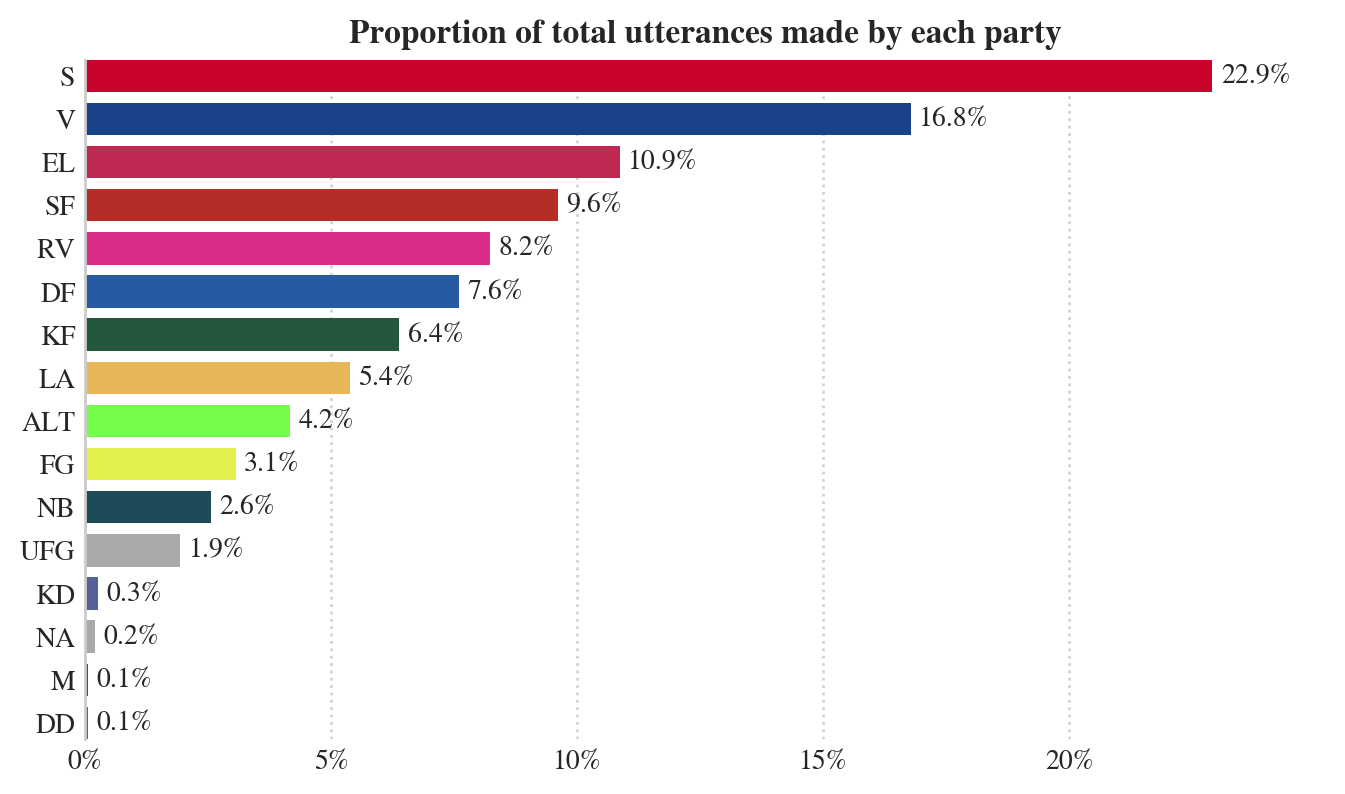

In [7]:
fig, ax = plt.subplots(figsize = (8,4.5))
bar_labs = party_counts['party'] * 100

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.barh(party_counts.index, width = party_counts['party'], height = 0.75, color = party_counts['color'])
ax.margins(0.1, 0)
ax.yaxis.grid(False)
ax.xaxis.grid(color='lightgrey', linestyle=':', linewidth=1) 
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.bar_label(ax.containers[0], labels=[f'{lab:,.1f}%' for lab in bar_labs.values], padding = 3)

plt.title('Proportion of total utterances made by each party', weight = 'bold')
plt.show()

In [8]:
party_counts = pd.DataFrame(
    df
    .groupby('source')['party']
    .value_counts(normalize = True)
    .sort_values(ascending = False)
).rename(columns = {'party': 'prop'})
party_counts = party_counts.reset_index()
party_counts['color'] = party_counts['party'].map(colormap).fillna('darkgrey')

new_cmap = (
    party_counts[['party', 'color']]
        .drop_duplicates(subset = 'party')
        .set_index('party')
        .T
        .to_dict(orient = 'records')[0]
)

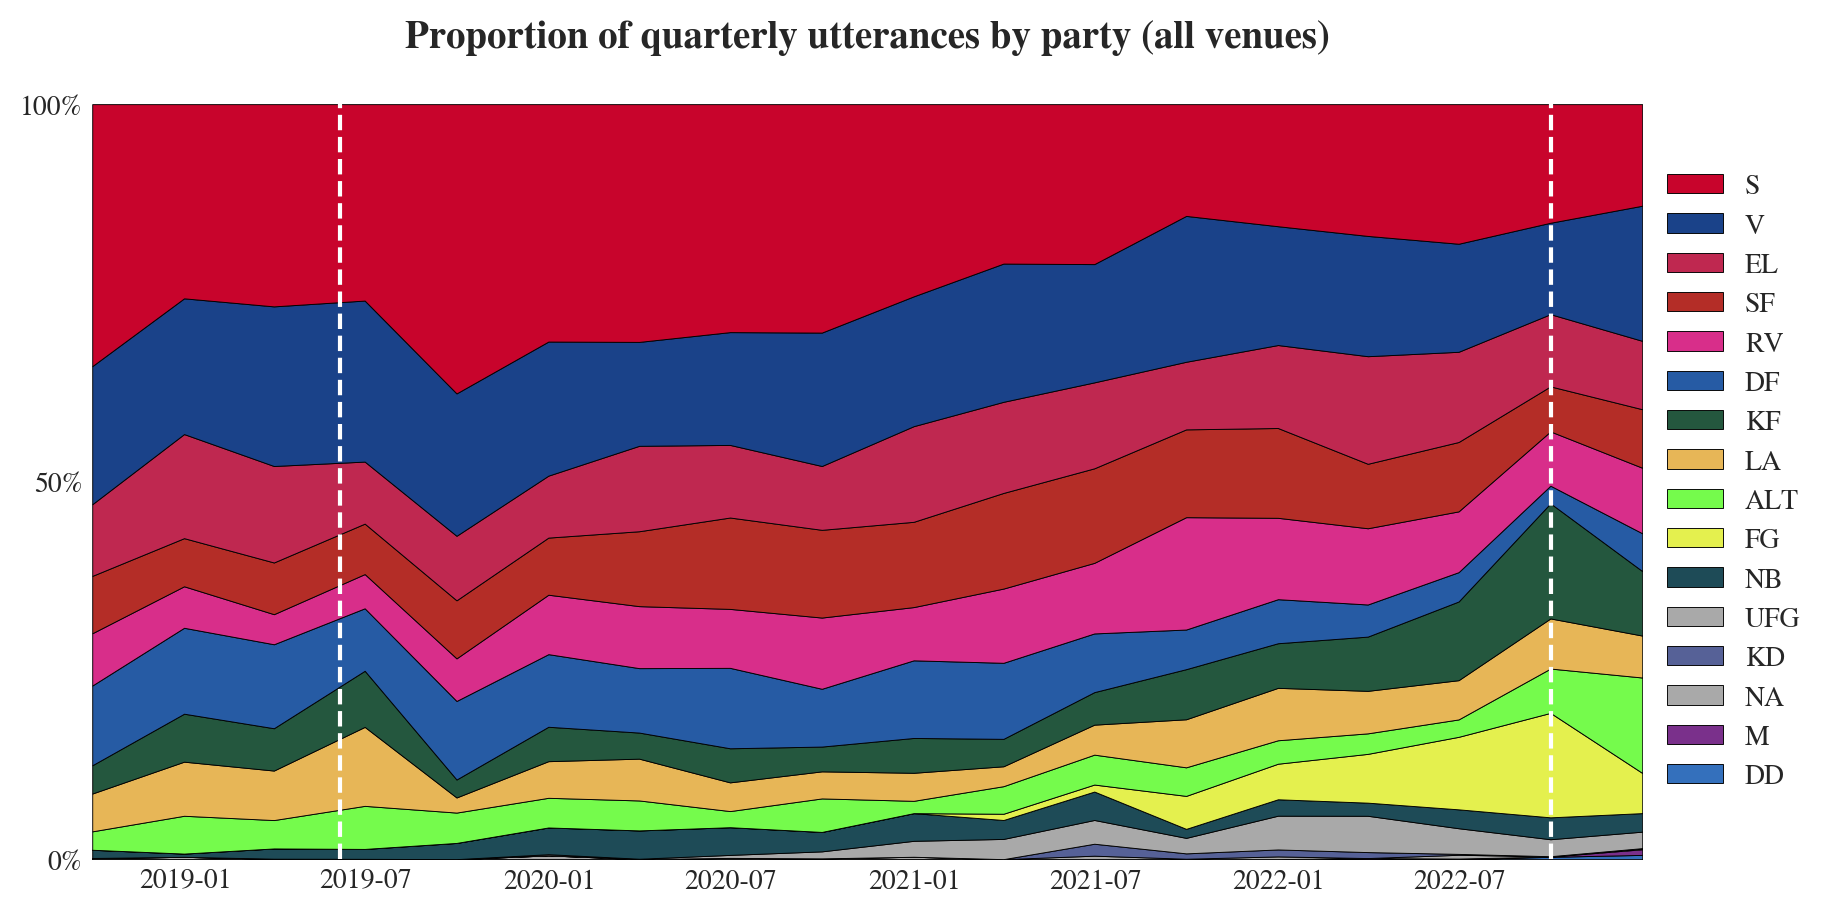

In [9]:
plot_timeseries_volume(
    df,
    cmap = new_cmap,
    interval = 'Q',
    constrain_source = False,
    title = True
)

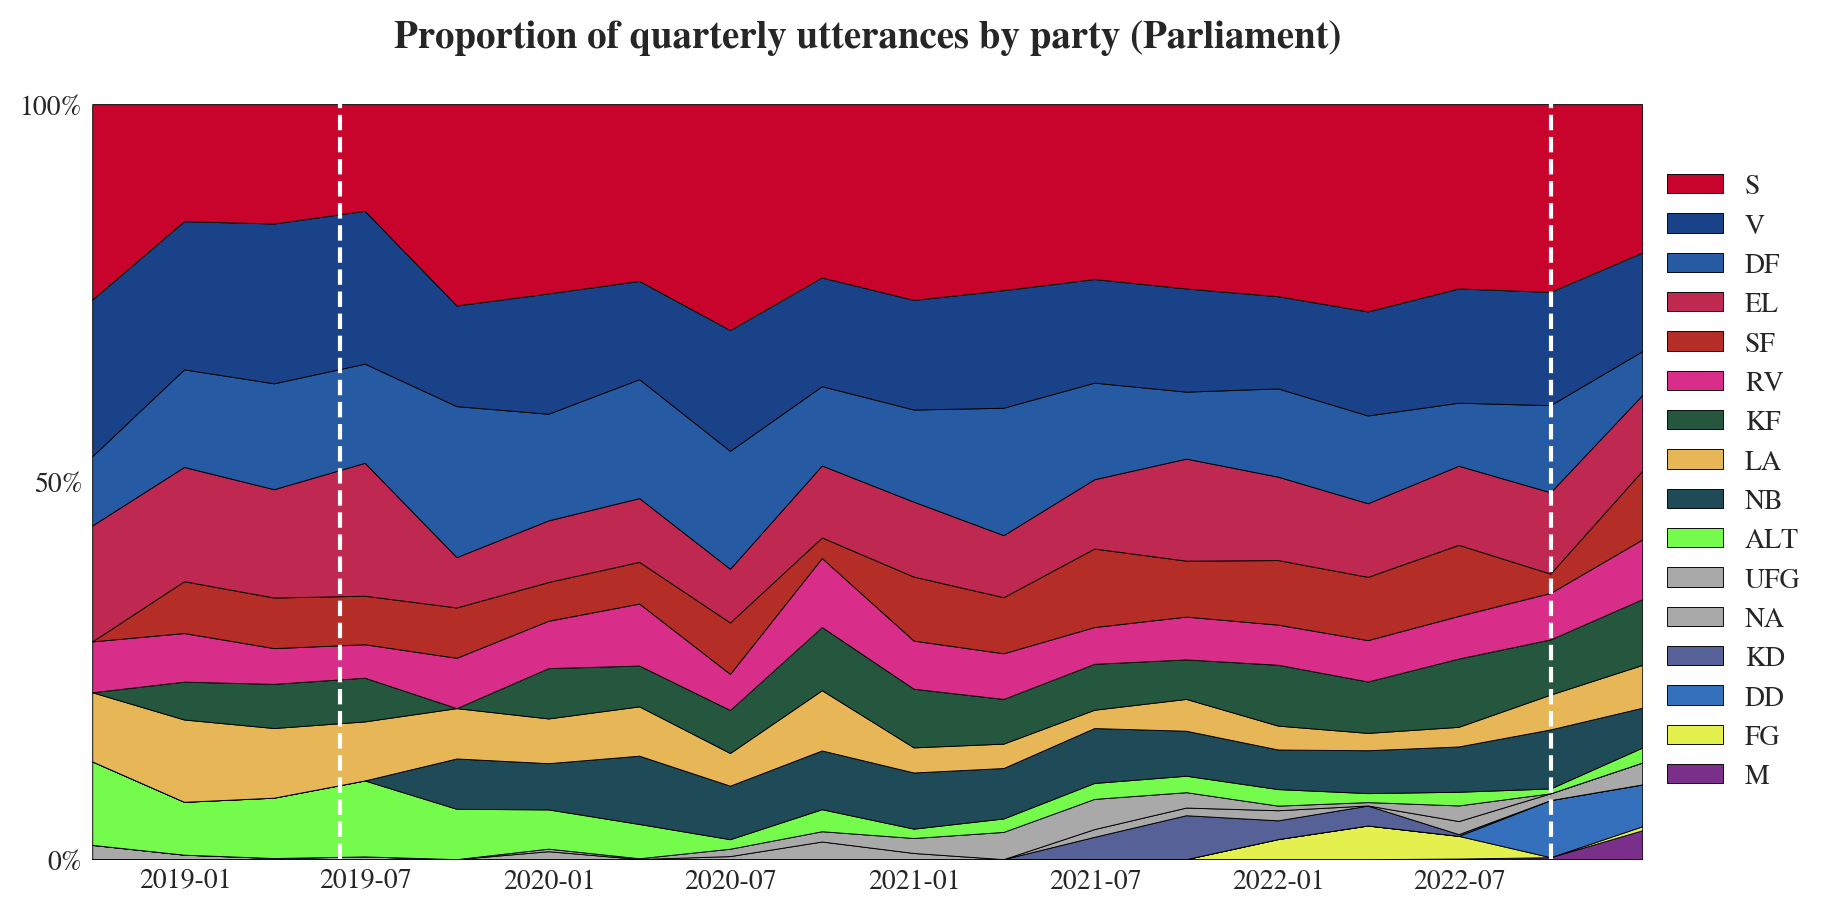

In [12]:
plot_timeseries_volume(
    df,
    cmap = new_cmap,
    interval = 'Q',
    constrain_source = 'parliament',
    title = True
)

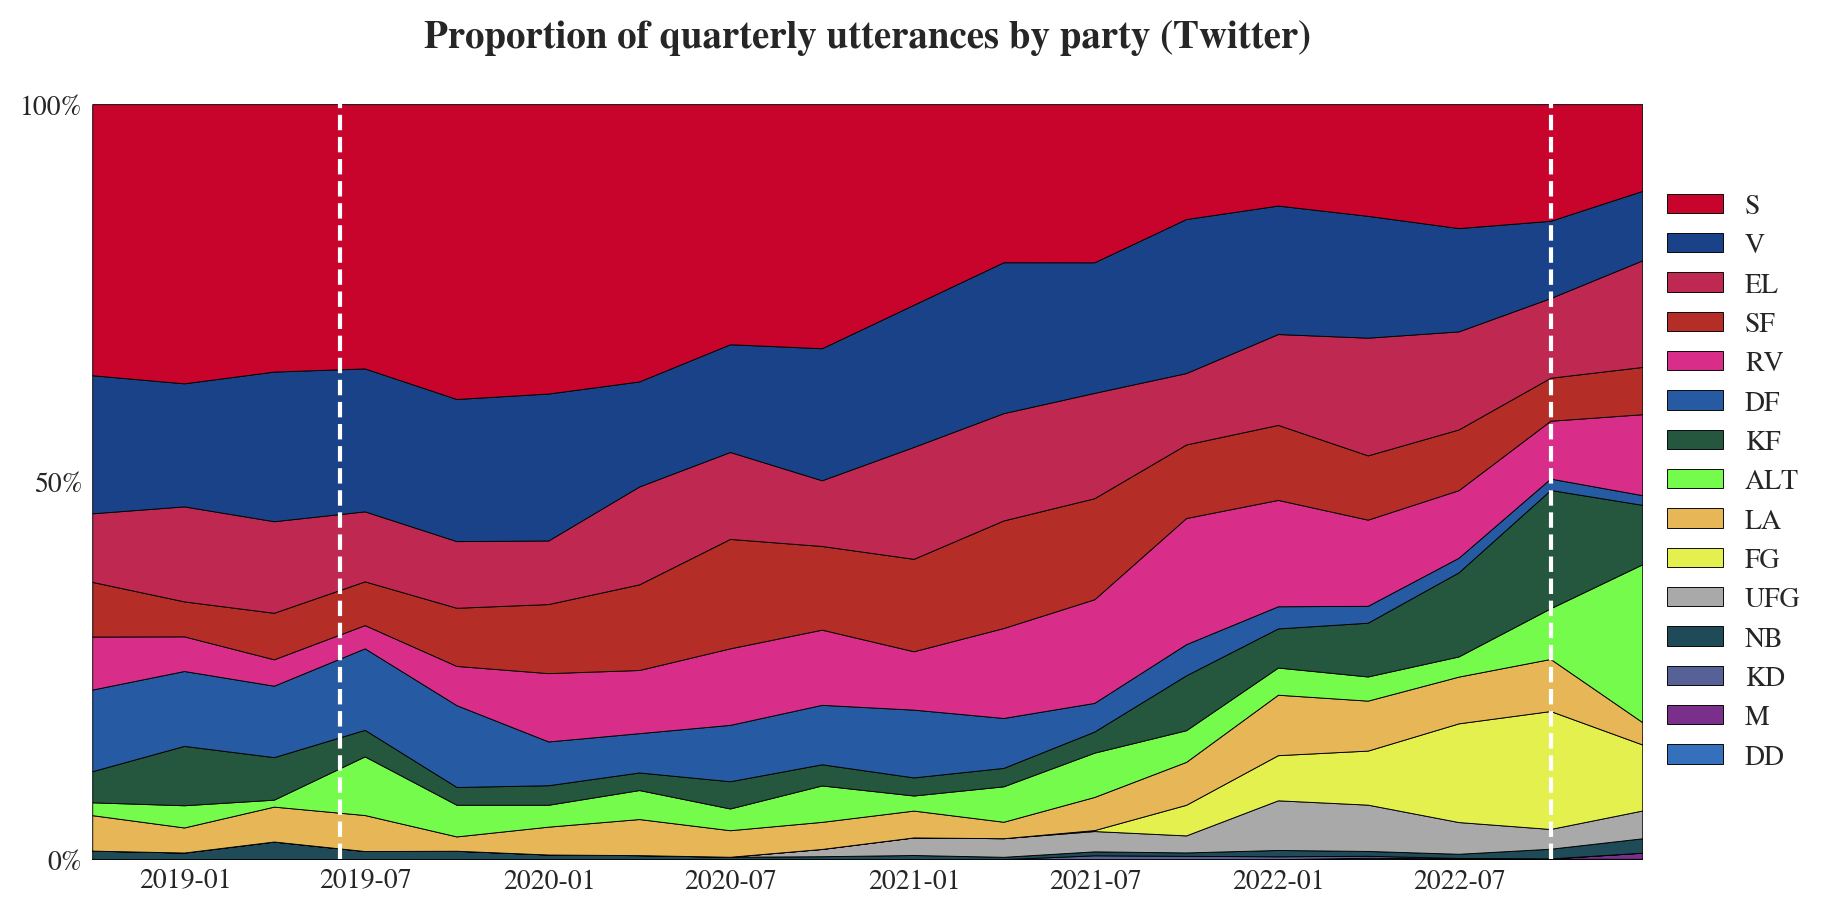

In [13]:
plot_timeseries_volume(
    df,
    cmap = new_cmap,
    interval = 'Q',
    constrain_source = 'twitter',
    title = True
)

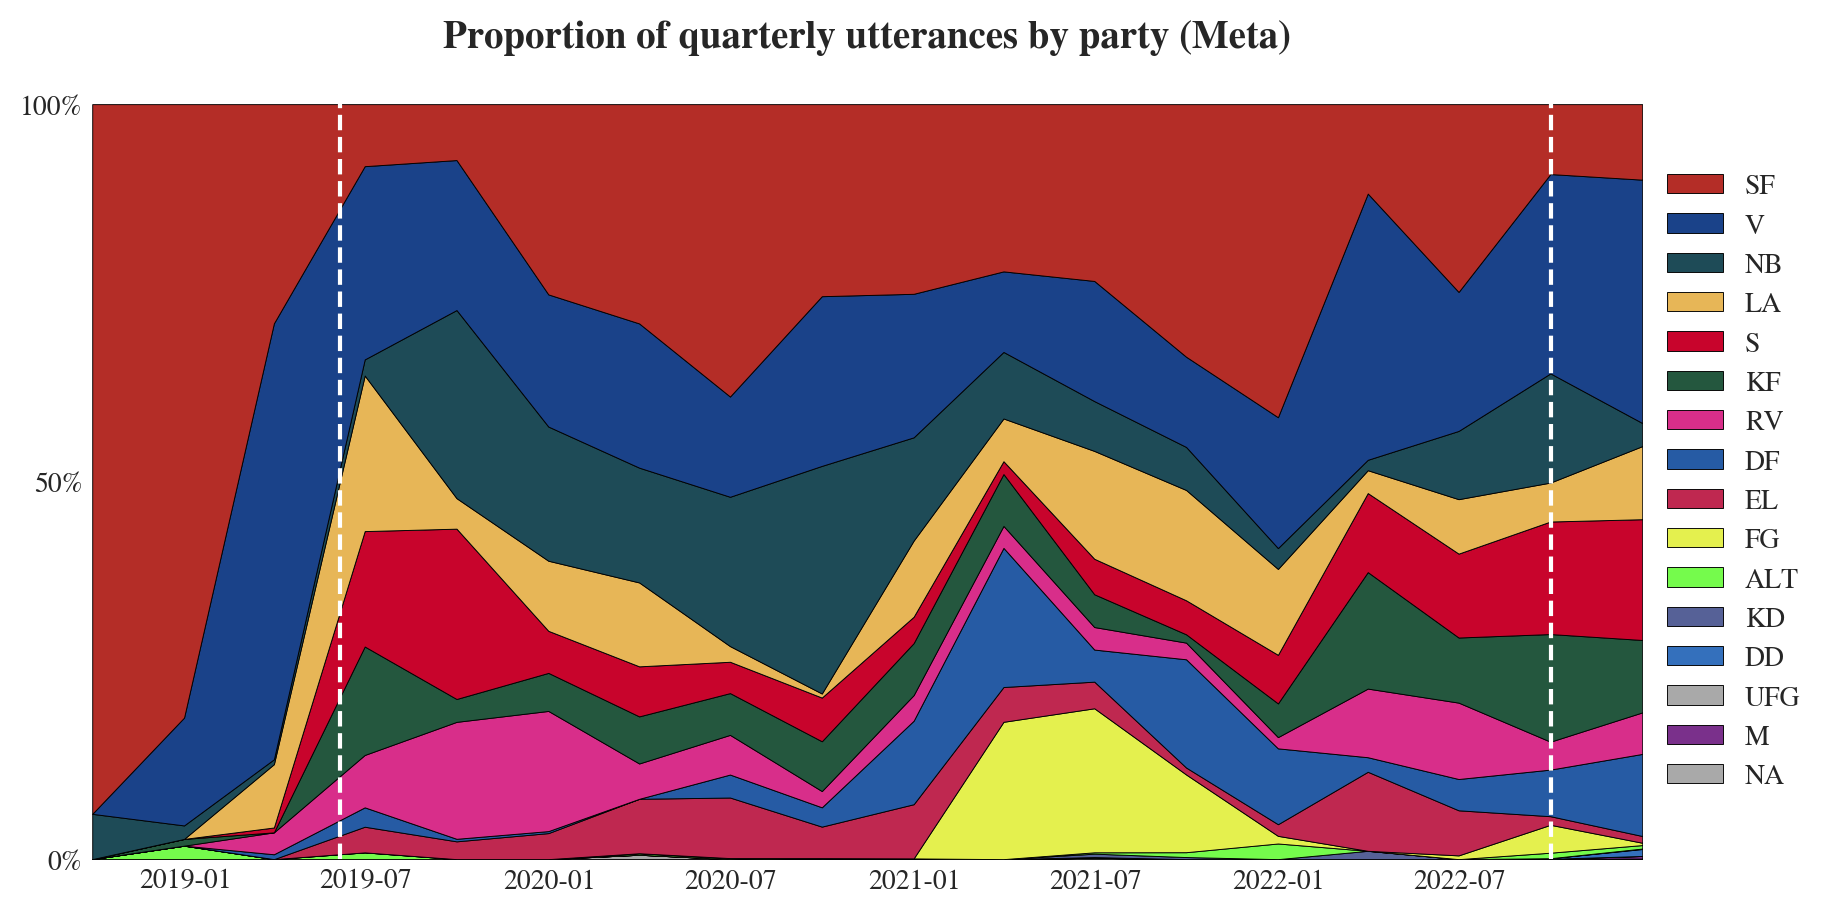

In [14]:
plot_timeseries_volume(
    df,
    cmap = new_cmap,
    interval = 'Q',
    constrain_source = 'meta',
    title = True
)

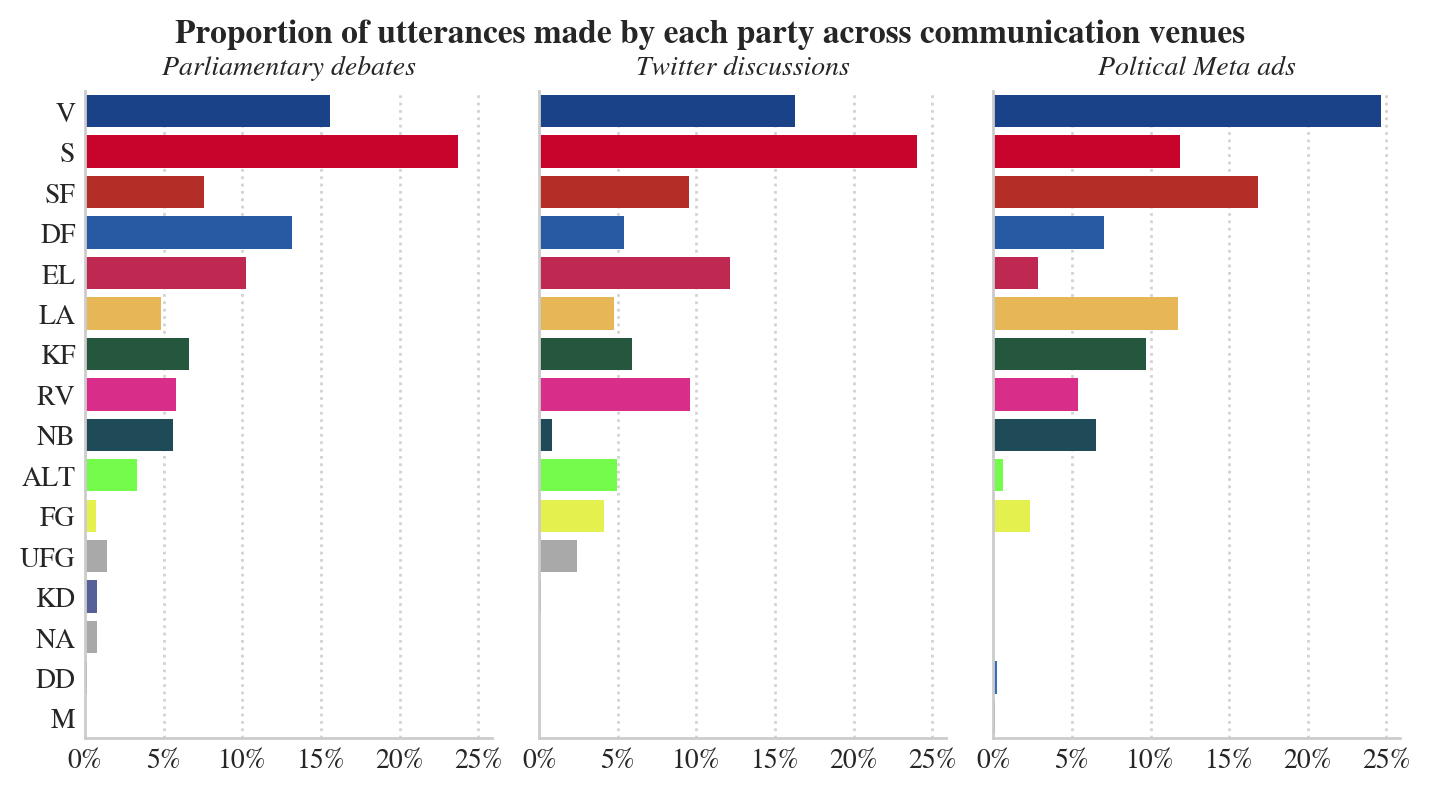

In [15]:
g = sns.catplot(
    data = party_counts,
    y = 'party',
    x = 'prop',
    palette = new_cmap,
    kind = 'bar',
    orient = 'h',
    col = 'source',
    height = 4, 
    aspect = 0.6,
    margin_titles = True,
    col_order = ['parliament', 'twitter', 'meta'],
    saturation = 1
)

for ax in g.axes.flat:
    ax.xaxis.grid(color='lightgrey', linestyle=':', linewidth=1) 
    plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

col_labs = ['Parliamentary debates', 'Twitter discussions', 'Poltical Meta ads']

for i, lab in enumerate(col_labs):
    g.axes.flat[i].set_title(lab, style='italic', size = 10)
    #print(ax.containers[0])#ax.bar_label(ax.containers[0], labels=[f'{lab:,.1f}%' for lab in bar_labs.values], padding = 3)

g.fig.subplots_adjust(top=0.89)
g.fig.suptitle('Proportion of utterances made by each party across communication venues', weight = 'bold')
plt.show()

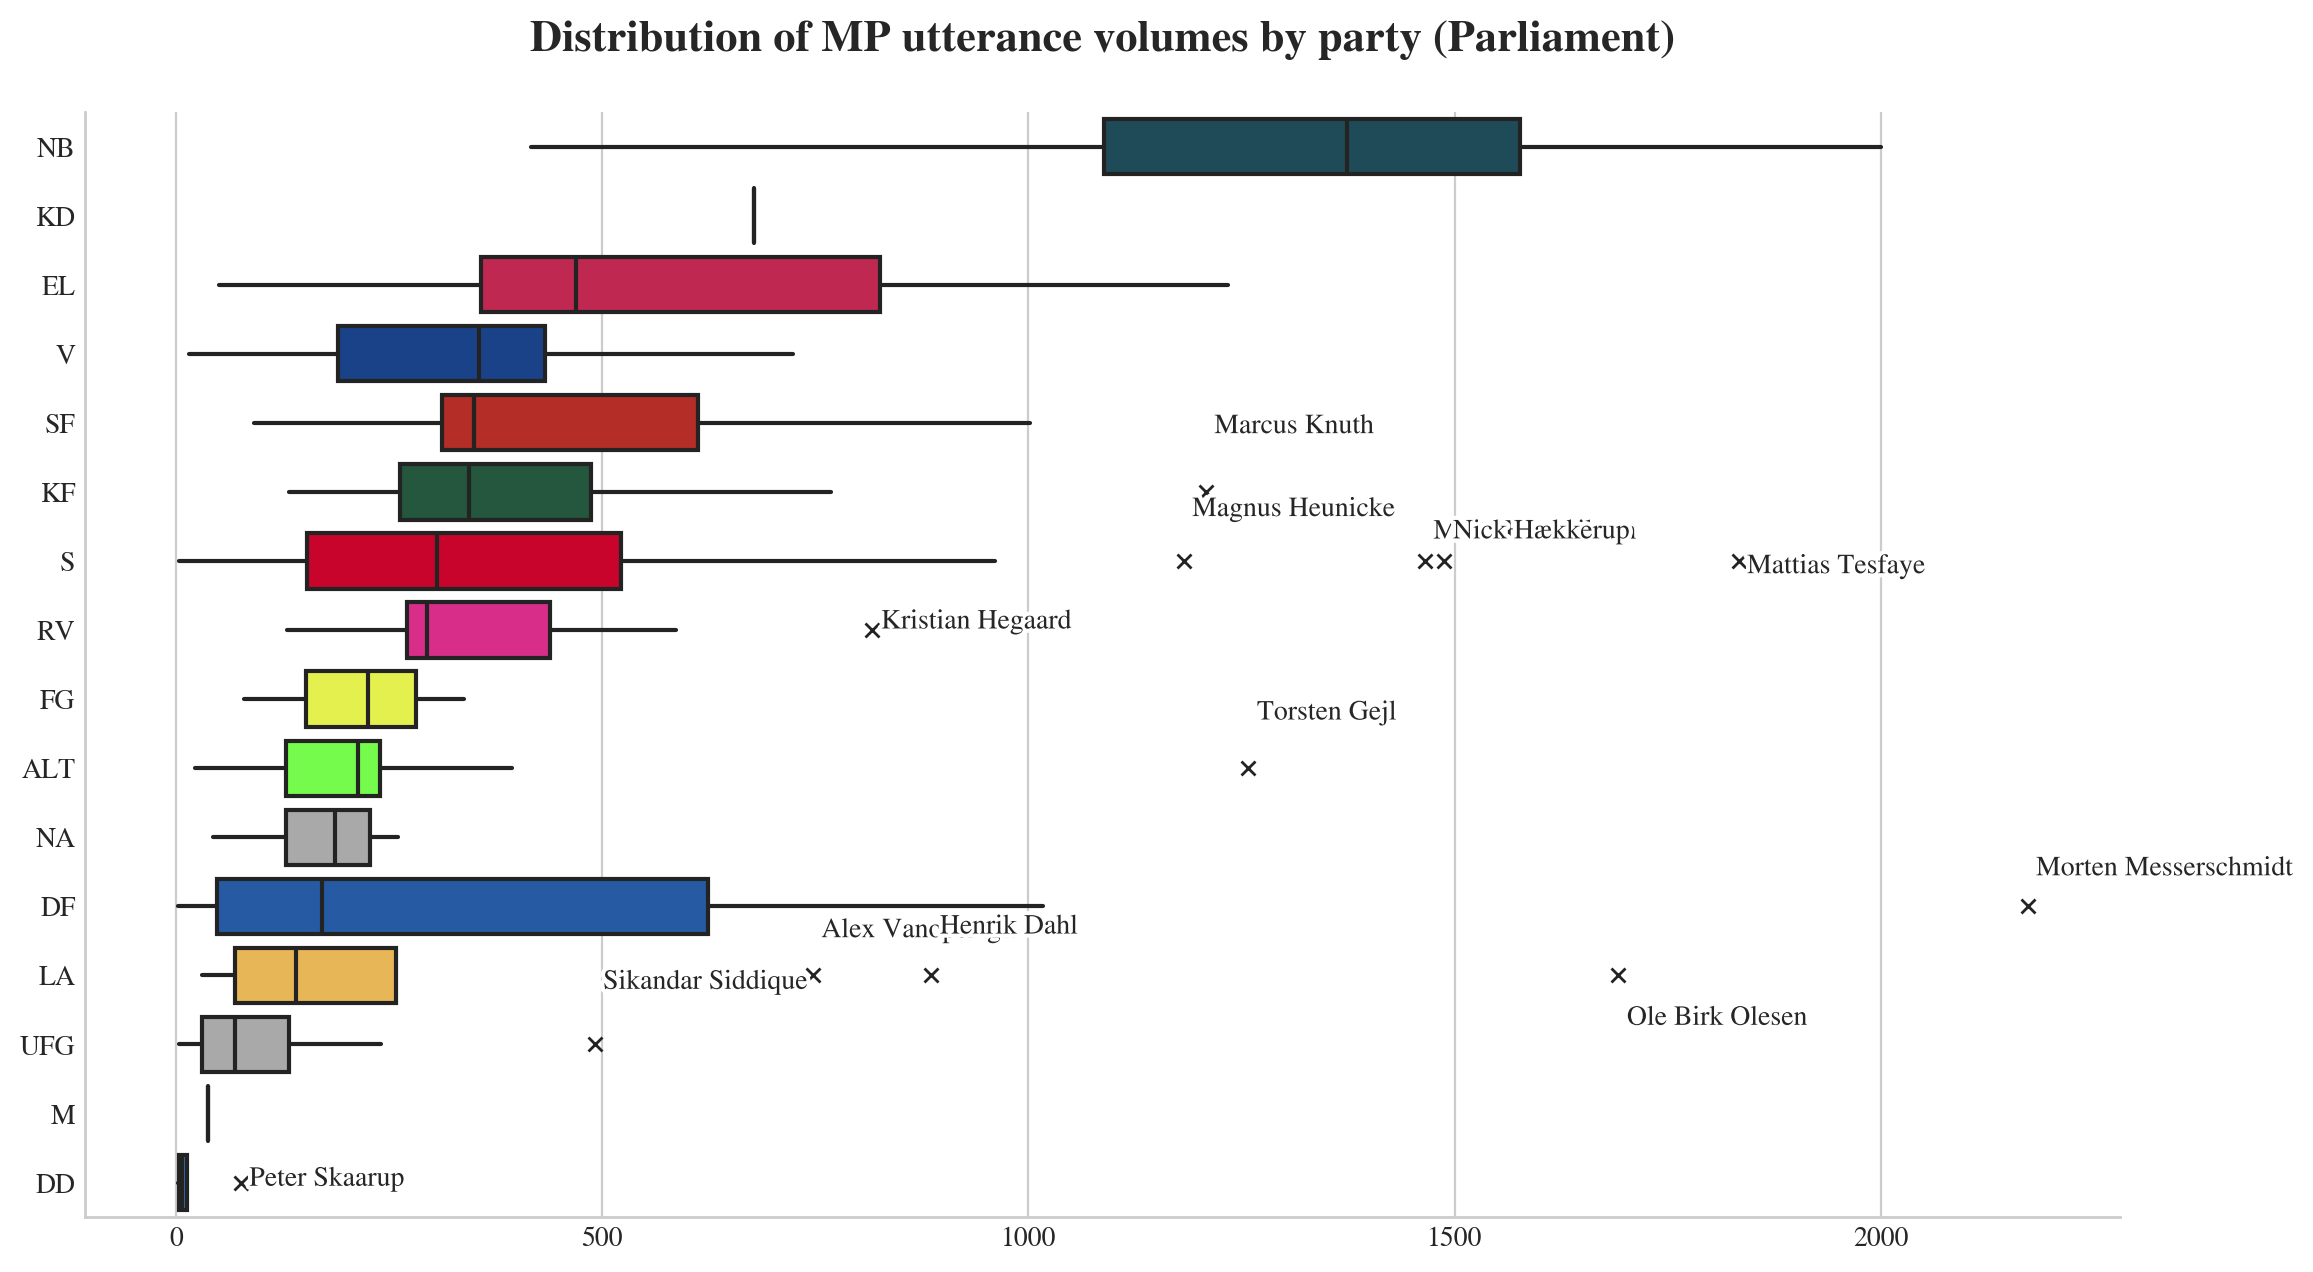

In [16]:
draw_volume_boxes(
    df,
    cmap = new_cmap,
    source = 'parliament',
    label_jitter = 1,
    title = True
)

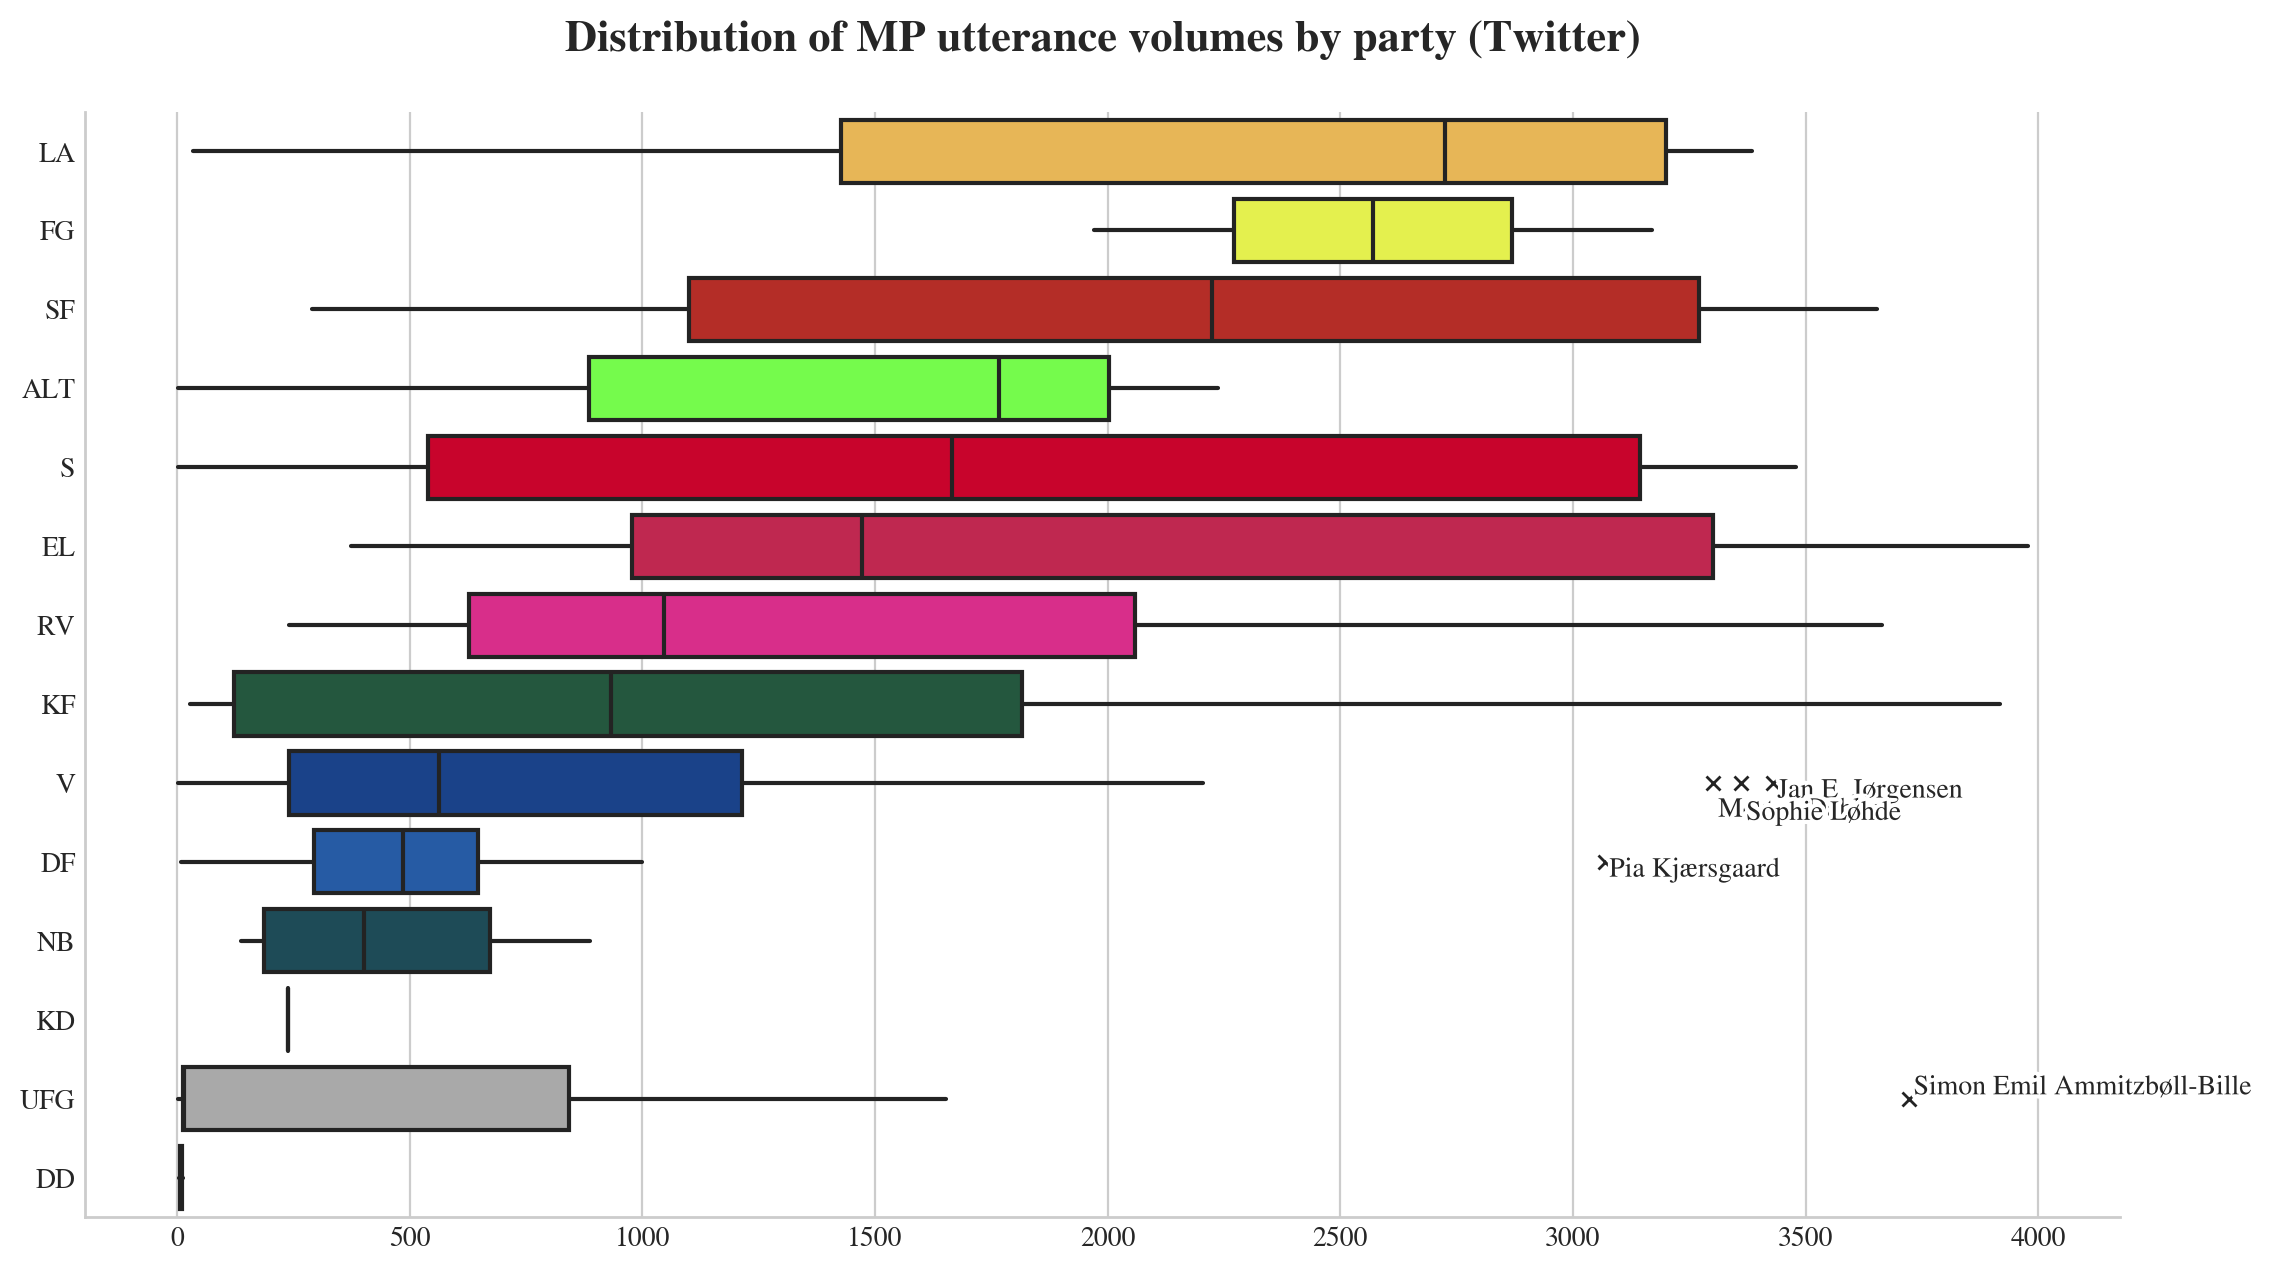

In [18]:
draw_volume_boxes(
    df,
    cmap = new_cmap,
    source = 'twitter',
    label_jitter = 0.5,
    #remove_list = ['UFG'],
    title = True
)

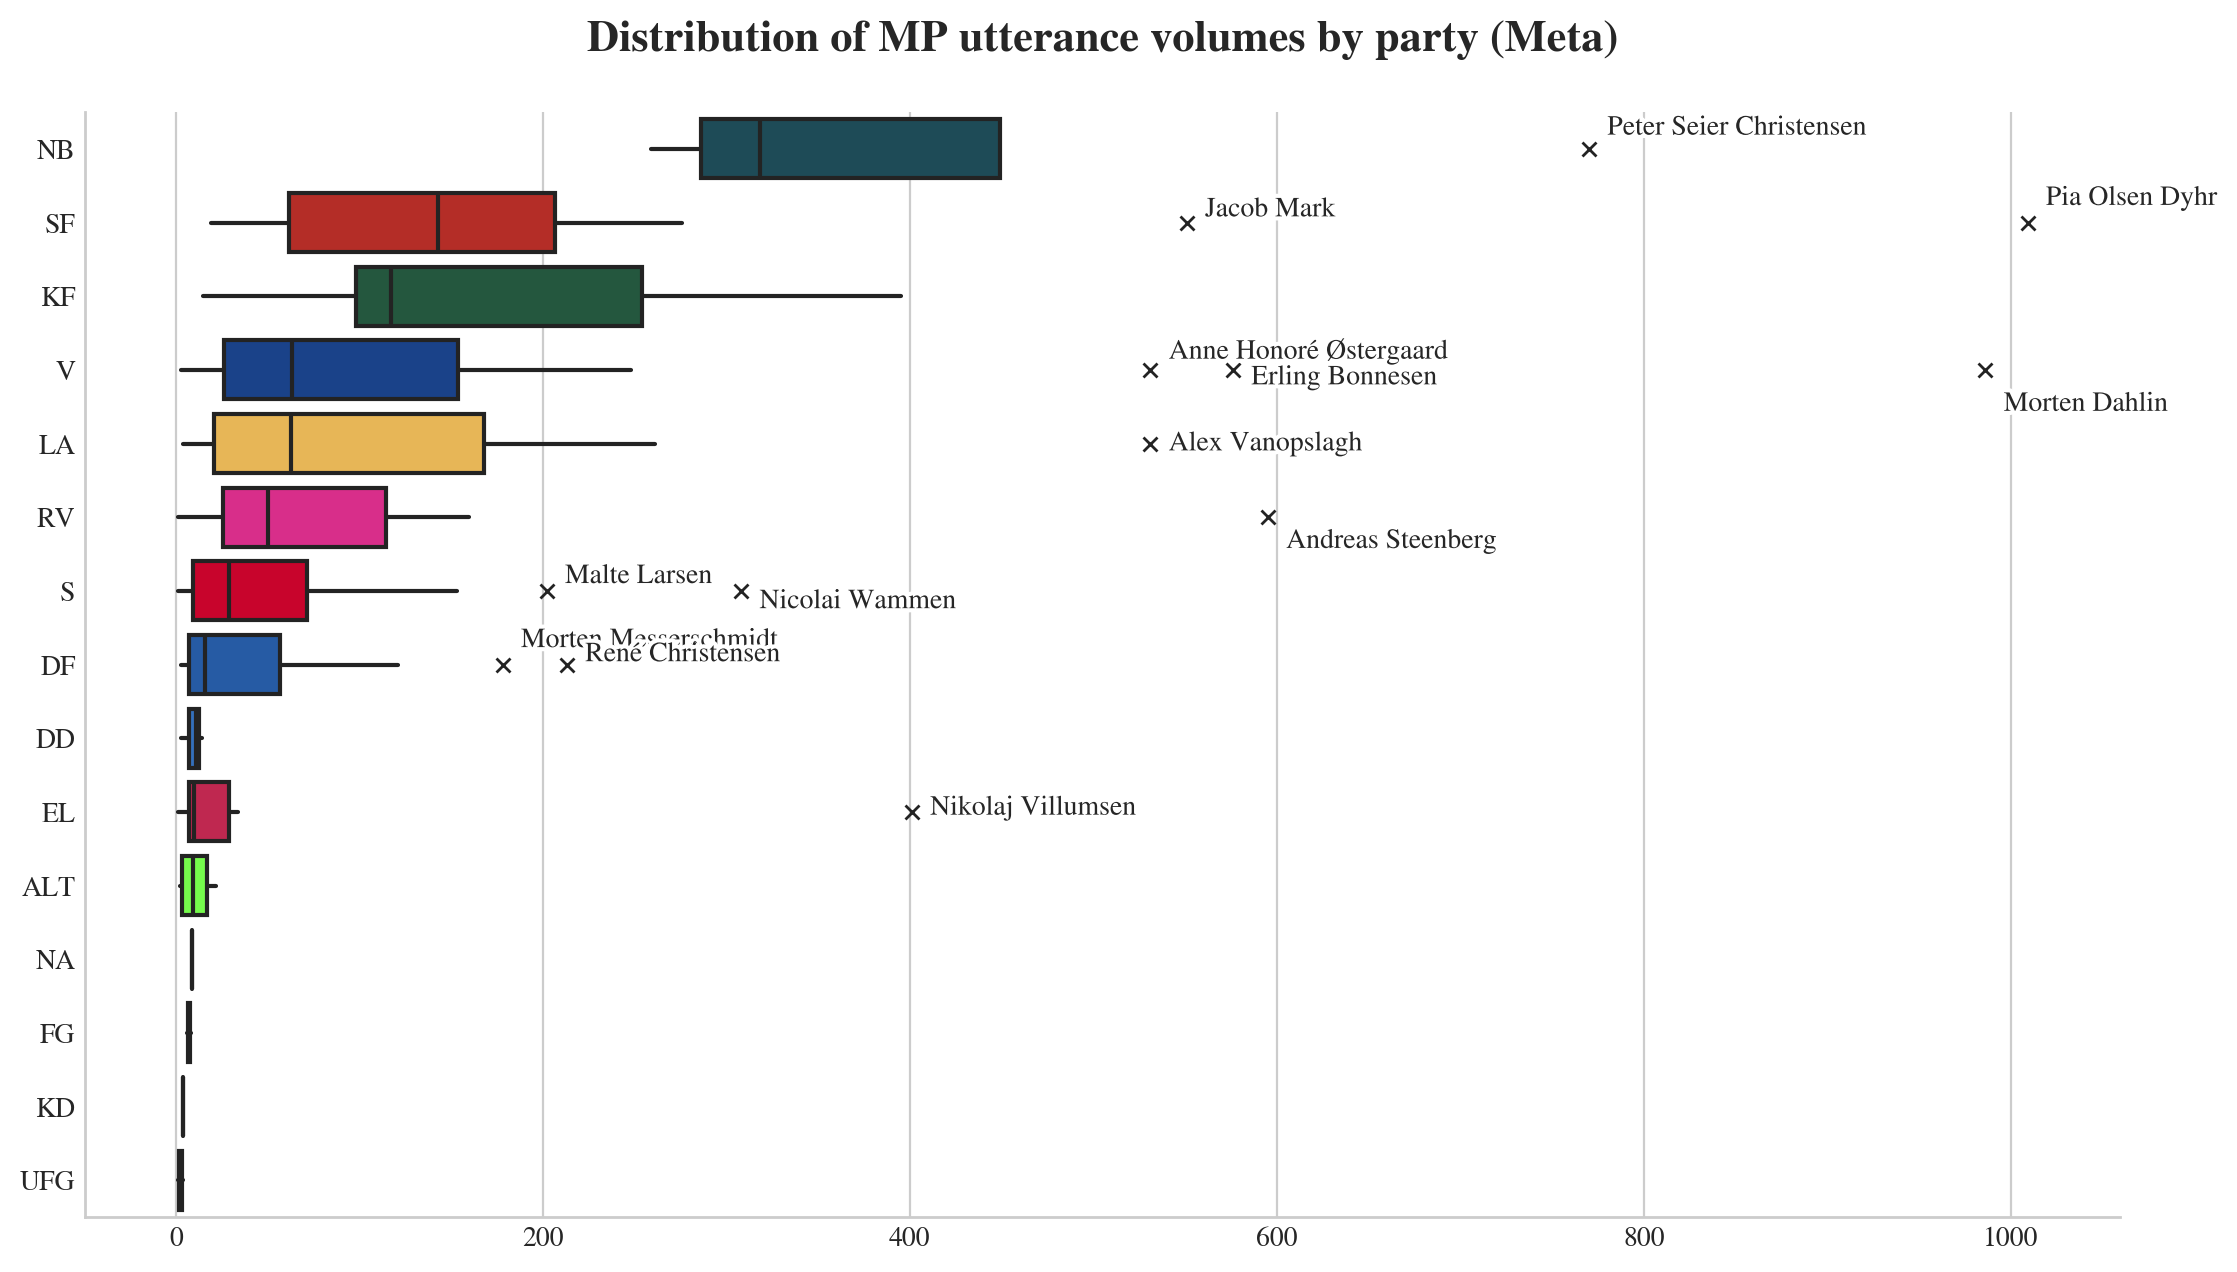

In [21]:
draw_volume_boxes(
    df,
    cmap = new_cmap,
    source = 'meta',
    label_jitter = 0.5,
    title = True
)

_____

# Common words

In [8]:
from politician2vec.utils import preproc_docs

def get_most_common_words(source, parties, top = 0, bottom = 50):
    '''
    TODO...
    '''
    
    filter = (df['source'] == source) & (df['party'].isin(parties))

    docs = ''.join([doc for doc in df.loc[filter, 'doc']])
    pp_docs = preproc_docs(docs)
    
    counts = pd.value_counts(np.array(pp_docs), normalize = True)[top:bottom]
    
    return counts

In [50]:
get_most_common_words('twitter', parties = ['EL', 'ALT'], top = 0, bottom = 50)

dkpol           0.015116
så              0.009653
kan             0.009522
the             0.004767
vores           0.004381
mere            0.004281
ved             0.003670
dag             0.003632
to              0.003144
helt            0.003108
godt            0.002885
få              0.002853
flere           0.002790
danmark         0.002679
år              0.002620
💚               0.002538
tak             0.002513
må              0.002495
dkgreen         0.002474
enhedslisten    0.002453
lige            0.002452
alternativet    0.002404
️               0.002367
’               0.002362
regeringen      0.002333
of              0.002240
bare            0.002214
in              0.002145
s               0.002097
andre           0.001998
får             0.001980
kommer          0.001977
a               0.001887
grønne          0.001871
brug            0.001860
går             0.001849
derfor          0.001826
and             0.001802
kun             0.001799
danske          0.001757
